In [1]:
!pip -q install doubleml==0.9.3 lightgbm --no-warn-script-location #instalamos esta version de doubleml

import pandas as pd
import numpy as np
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier #aplicamos random forest porque es interesante ante relaciones no lineales, pero es recomendable probar distintos modelos
from google.colab import files, data_table
import io, re
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.9/342.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 61.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.8 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


# Diff-in-Diff Calculator

## Índice rápido
1. Instalación
2. Carga del CSV + formato
3. Transformación ΔY
4. `DoubleMLData`
5. Estimación Diff-in-diff
6. Diagnóstico y resultado

## 2. Carga del CSV

En esta celda tienes lo siguiente:

* Te pedirá un CSV en local. Si no lo subes el resto de celdas no arrancarán
* He creado algunas lógicas de deccimales y comas, pero ten esto en cuenta de cara a la ccarga del CSV.
* Hace un poco de limpieza y cconvierte las columnas a numéricas.  
* También he hecho que compruebe columnas obligatorias y que cada id tenga los dos periodos.

## Formato requerido del CSV

Tu archivo **debe estar en este formato**:

| Columna | Tipo esperado | Descripción |
|---------|---------------|-------------|
| `id`    | entero / cadena | Identificador único de la unidad (empresa, persona, región…) |
| `time`  | entero | Periodo temporal. 0 = pre‑tratamiento, 1 = post‑tratamiento.<br>Si tienes múltiples años, puedes usar valores naturales (2018, 2019…). |
| `D`     | 0 / 1          | Indicador de tratamiento: 1 si la unidad pertenece al grupo tratado, 0 si es control. **Debe permanecer constante** en el tiempo. |
| `Y`     | numérico       | Variable de resultado que deseas analizar. |
| `X*`    | numérico o dummies | Covariables opcionales observadas **antes** del tratamiento (edad, sector, tamaño, etc.).<br>Se pueden incluir tantas como quieras. **No son obligatorias** |

**Reglas clave**

1. Cada `id` debe aparecer **al menos** en los periodos pre y post.
2. No debe haber valores perdidos en `id`, `time`, `D` ni `Y`.
3. Si usas separadores de miles o comas decimales, el cargador los corrige, pero evita mezclarlos.
4. Las covariables categóricas deben estar ya codificadas en dummies (0/1).
5. Si tu panel tiene más de dos periodos, la calculadora tomará automáticamente los pares 0/1 para el efecto principal y usará los negativos
   (–1, –2…) para tests de pre‑tendencia si están disponibles.

In [2]:
uploaded = files.upload()
fname = next(iter(uploaded))
raw = uploaded[fname]

#Con esto monto la lectura estándar
try:
    df = pd.read_csv(io.BytesIO(raw))
except Exception:
    df = pd.read_csv(io.BytesIO(raw), decimal=',', thousands='.')

df.columns = df.columns.str.strip() #elimina espacios de las columnas
obj_cols = df.select_dtypes(include=['object']).columns #se convierten a numérico, vigila porque en ocasiones puede transformar números.
for col in obj_cols:
    #sustituye decimal "," por "."
    df[col] = (df[col]
               .str.replace(r'\.(?=\d{3}(,|$))', '', regex=True)  #Usamos "." para los 1.000
               .str.replace(',', '.', regex=False))
    df[col] = pd.to_numeric(df[col], errors='ignore')

#Fuerzo que sean integers, me he encontrado problemas con la librería
for col in ['id', 'time', 'D']:
    df[col] = pd.to_numeric(df[col], errors='raise').astype(int)

display(df.head())
required = {'id','time','D','Y'}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Faltan columnas {missing}")

bad_ids = df.groupby('id')['time'].nunique().lt(2).sum()
if bad_ids:
    raise ValueError(f"{bad_ids} ids no tienen los dos periodos obligatorios.")

print("Datos validados ✔️")


Saving example_did_clean.csv to example_did_clean.csv


,id,time,D,Y,X1,X2
0,1,0,1,13.538986,9.296161,-1.265934
1,1,1,1,18.174141,9.296161,-1.265934
2,2,0,0,7.370205,3.163756,0.119827
3,2,1,0,9.312400,3.163756,0.119827
4,3,0,1,6.523420,1.839188,-1.063512


Datos validados ✔️


In [3]:
#EValuamos cuántos usuarios (unidades) tenemos en cada grupo
n_treated = (df['D'] == 1).sum()
n_control = (df['D'] == 0).sum()
print(f"Nº unidades tratadas: {n_treated}, controles: {n_control}")
if min(n_treated, n_control) < 20:
    print("⚠️  Advertencia: grupos muy pequeños; la precisión de las estimaciones puede ser baja.")

Nº unidades tratadas: 50, controles: 50


## 3. Transformación a diferencia (ΔY)

Se define pre y post. Ten en cuenta que eso se define por el 0 y el 1 de la columna "time".

In [4]:
#Se define entorno pre y post,
pre  = df[df['time']==0].drop_duplicates('id')
post = df[df['time']==1].drop_duplicates('id')

pair = pre.merge(post, on='id', suffixes=('_pre','_post'), how='inner')

#Outcome diff
pair['Y'] = pair['Y_post'] - pair['Y_pre']
pair['D'] = pair['D_post']

#Covariables baseline (tomadas del periodo pre)
x_cols = [c for c in pre.columns if c not in ['id','time','D','Y']]
for c in x_cols:
    pair[c] = pair[f'{c}_pre']

df_diff = pair[['id','Y','D'] + x_cols].copy()
df_diff = df_diff.replace([np.inf,-np.inf], np.nan).dropna() #tuve que hacer una limpieza de NA por si acaso.
print("df_diff shape:", df_diff.shape)
display(df_diff.head())


df_diff shape: (50, 5)


,id,Y,D,X1,X2
0,1,4.635155,1,9.296161,-1.265934
1,2,1.942195,0,3.163756,0.119827
2,3,3.632545,1,1.839188,-1.063512
3,4,2.127358,0,2.045603,0.332883
4,5,1.573443,0,5.677250,-2.359419


Máx. standardized mean diff.: 0.042


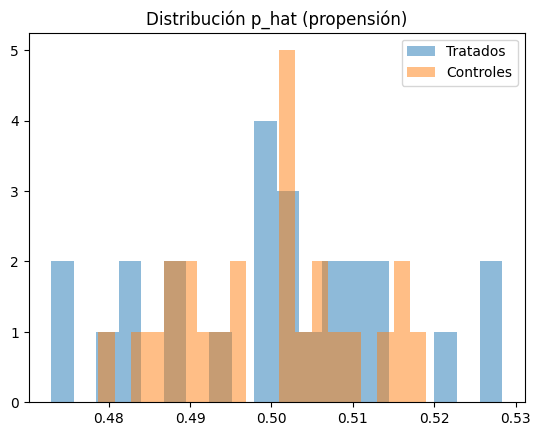

Solapamiento dentro de 0.05‑0.95: 100%


In [5]:
# Definimos una diferencia estandarizada. No es obligatorio en el 100% de los casos pero puede ser buena práctia
def std_diff(col):
    treat = df_diff[df_diff['D']==1][col]
    ctrl  = df_diff[df_diff['D']==0][col]
    pooled_sd = (0.5*(treat.var()+ctrl.var()))**0.5
    return abs(treat.mean() - ctrl.mean()) / pooled_sd

imbal = {c: std_diff(c) for c in x_cols}
max_imb = max(imbal.values()) if imbal else 0
print('Máx. standardized mean diff.:', round(max_imb,3))
if max_imb > 0.25:
    print('⚠️  Desbalance potencialmente problemático (>0.25)')

logit = LogisticRegression(max_iter=1000) #Comprueba el solapamiento de las puntuaciones de propensión, que estiman la probabilida de ser tratado, para asegurar grupos comparables.
logit.fit(df_diff[x_cols], df_diff['D'])
p_hat = logit.predict_proba(df_diff[x_cols])[:,1]
df_diff['p_hat'] = p_hat

plt.hist(df_diff[df_diff['D']==1]['p_hat'], bins=20, alpha=0.5, label='Tratados')
plt.hist(df_diff[df_diff['D']==0]['p_hat'], bins=20, alpha=0.5, label='Controles')
plt.title('Distribución p_hat (propensión)')
plt.legend(); plt.show()

overlap = ((p_hat > 0.05) & (p_hat < 0.95)).mean()
print(f'Solapamiento dentro de 0.05‑0.95: {overlap:.0%}')
if overlap < 0.90:
    print('⚠️  Poco solapamiento; considera métodos alternativos') #aqui le metemos un poco de logica al output y un poco de recomendacion para que sea mas playful :)

## Evolución media de `Y` por grupo
Visualizamos la trayectoria temporal de la media de **Y** para usuarios que han sido tratados y usuarios que son de control antes de construir las diferencias. Esto será fundamental para comparar el "antes y después".

* 0 = Periodo pre
* 1 = periodo post

D,Control (D=0),Tratado (D=1)
time,,
0,9.610063,9.618234
1,11.959345,13.965416


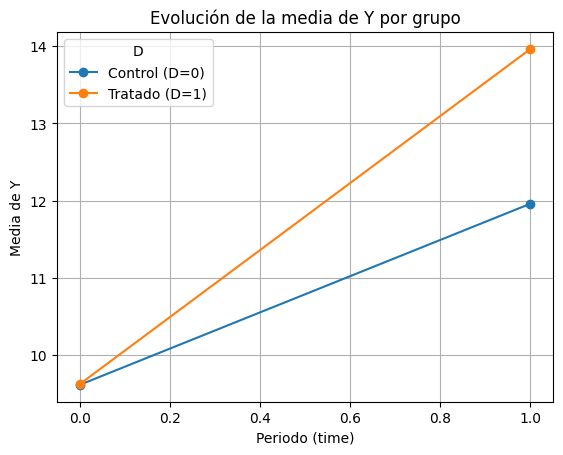

In [6]:
# Media de Y por periodo y grupo de tratamiento.
mean_traj = (
    df.groupby(['time', 'D'])['Y']
      .mean()
      .reset_index()
      .pivot(index='time', columns='D', values='Y')
      .rename(columns={0: 'Control (D=0)', 1: 'Tratado (D=1)'})
)

display(mean_traj)

import matplotlib.pyplot as plt
mean_traj.plot(marker='o')
plt.title('Evolución de la media de Y por grupo')
plt.xlabel('Periodo (time)')
plt.ylabel('Media de Y')
plt.grid(True)
plt.show()


## 4. Construcción de `DoubleMLData`

Declaramos la variable dml_data para estructurar y organizar los datos de manera que sean compatibles con los modelos de DoubleML. Facilita la declaración de los roles de las variables (resultado, tratamiento y covariables) para que la librería pueda aplicar correctamente sus algoritmos de Machine Learning y procedimientos de inferencia causal.

In [7]:
x_cols = [c for c in df_diff.columns if c not in ['id','Y','D']]
dml_data = dml.DoubleMLData(df_diff, y_col='Y', d_cols='D', x_cols=x_cols)
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['D']
Covariates: ['X1', 'X2', 'p_hat']
Instrument variable(s): None
No. Observations: 50

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 6 entries, id to p_hat
dtypes: float64(4), int64(2)
memory usage: 2.5 KB



## 5. Estimación Difference‑in‑Differences

*Desde la versión 0.9 de* **DoubleML**, el parámetro `score` acepta únicamente
`'observational'` (ATT) o `'experimental'` (ATE). Aquí usamos `'observational'`* para estimar el efecto medio en los tratados.

In [8]:
# Learners
ml_g = RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)
ml_m = RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

# En DoubleML >=0.9 los scores válidos son 'observational' (ATT) y 'experimental' (ATE)
dml_did = dml.DoubleMLDID(dml_data, ml_g=ml_g, ml_m=ml_m, score='observational')  # ATT
dml_did.fit()
print(dml_did.summary)


       coef   std err         t         P>|t|     2.5 %    97.5 %
D  2.331486  0.428168  5.445265  5.172827e-08  1.492293  3.170679


In [9]:
# ---------- Interpretación del coeficiente ATT ----------
coef_att = dml_did.coef[0]
se_att   = dml_did.se[0]
print(f"""\nEfecto estimado (ATT): {coef_att:,.3f}
Error estándar:       {se_att:,.3f}
IC 95%:               [{coef_att - 1.96*se_att:,.3f}, {coef_att + 1.96*se_att:,.3f}]
\nInterpretación:
  • ATT (Average Treatment effect on the Treated) en el marco DiD+DoubleML:
    diferencia media en Y para las unidades tratadas respecto a su contrafactual
    (cómo habrían evolucionado sin tratamiento), bajo supuestos de tendencias
    paralelas y sin confusores no observables relacionados con el tiempo.
""")


Efecto estimado (ATT): 2.331
Error estándar:       0.428
IC 95%:               [1.492, 3.171]

Interpretación:
  • ATT (Average Treatment effect on the Treated) en el marco DiD+DoubleML:
    diferencia media en Y para las unidades tratadas respecto a su contrafactual
    (cómo habrían evolucionado sin tratamiento), bajo supuestos de tendencias
    paralelas y sin confusores no observables relacionados con el tiempo.



## 6. Diagnóstico de supuestos para aplicar Diff-in-diff

El supuesto de tendencias paralelas indica que, en ausencia de la intervención, la evolución de la variable de resultado habría sido la misma para el grupo tratado y el grupo de control. Este test es una forma importante de verificar si los grupos (tratado y control) seguían tendencias similares antes de la intervención real.

In [10]:
# Pseudo pre‑trend test si hay periodos t=-1
if (-1 in df['time'].unique()):
    pre2 = df[df['time']==-1].drop_duplicates('id')
    pseudo = pre.merge(pre2, on='id', suffixes=('_t0','_tneg1'), how='inner')
    pseudo['Y'] = pseudo['Y_t0'] - pseudo['Y_tneg1']
    pseudo['D'] = pseudo['D_t0']
    for c in x_cols:
        pseudo[c] = pseudo[f'{c}_t0']
    dml_data_ps = dml.DoubleMLData(pseudo[['id','Y','D']+x_cols], 'Y', 'D', x_cols)
    dml_ps = dml.DoubleMLDID(dml_data_ps, ml_g=ml_g, ml_m=ml_m, score='ATTE')
    dml_ps.fit()
    print("Pseudo‑efecto (pre‑tratamiento):")
    print(dml_ps.summary)
else:
    print("No hay periodo t=-1 para test de tendencias paralelas.")


No hay periodo t=-1 para test de tendencias paralelas.


## ⚠️ Warnings:

1. **Heurísticos**  
   Lo implementado es en base a heurísticos. Si algo no te enacja, considera añadir covariables o ajustar.

3. **Modelos ML y tuning**  
   Se usan Random Forest y Logistic Regression con hiperparámetros fijos para
   simplificar. Valora *hyper‑parameter tuning* si necesitas algo más avanzado.

4. **Otras amenazas**  
   Revisa el contexto de tu aplicación antes de interpretar causalmente.
